In [45]:
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from geopy.distance import geodesic
from scipy.stats import norm

In [46]:
csv_path = os.path.join(os.getcwd(), "uber.csv")
df = pd.read_csv(csv_path)

In [47]:
df

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5
...,...,...,...,...,...,...,...,...,...
199995,42598914,2012-10-28 10:49:00.00000053,3.0,2012-10-28 10:49:00 UTC,-73.987042,40.739367,-73.986525,40.740297,1
199996,16382965,2014-03-14 01:09:00.0000008,7.5,2014-03-14 01:09:00 UTC,-73.984722,40.736837,-74.006672,40.739620,1
199997,27804658,2009-06-29 00:42:00.00000078,30.9,2009-06-29 00:42:00 UTC,-73.986017,40.756487,-73.858957,40.692588,2
199998,20259894,2015-05-20 14:56:25.0000004,14.5,2015-05-20 14:56:25 UTC,-73.997124,40.725452,-73.983215,40.695415,1


In [48]:
df['fare_amount'].describe()

count    200000.000000
mean         11.359955
std           9.901776
min         -52.000000
25%           6.000000
50%           8.500000
75%          12.500000
max         499.000000
Name: fare_amount, dtype: float64

In [49]:
# Define the condition to filter out rows with latitude/longitude values outside the [-90, 90] range
condition_out_of_range = (
    (df['pickup_longitude'] < -90) | (df['pickup_longitude'] > 90) |
    (df['pickup_latitude'] < -90) | (df['pickup_latitude'] > 90) |
    (df['dropoff_longitude'] < -90) | (df['dropoff_longitude'] > 90) |
    (df['dropoff_latitude'] < -90) | (df['dropoff_latitude'] > 90)
)

# Create a condition to filter out rows where fare_amount is less than or equal to 0
condition_invalid_fare = df['fare_amount'] <= 0

# Create a condition to filter out rows where any latitude/longitude column has NaN values
condition_nan_coordinates = (
    df['pickup_longitude'].isna() |
    df['pickup_latitude'].isna() |
    df['dropoff_longitude'].isna() |
    df['dropoff_latitude'].isna()
)

# Combine rows with values outside the range, invalid fare_amount, or NaN values in coordinates
condition_combined = condition_out_of_range | condition_invalid_fare | condition_nan_coordinates

# Extract rows that meet the combined condition into the 'dropped' DataFrame
dropped = df[condition_combined].copy()

# Remove these rows from the original DataFrame
df = df[~condition_combined].copy()

In [50]:
df

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5
...,...,...,...,...,...,...,...,...,...
199995,42598914,2012-10-28 10:49:00.00000053,3.0,2012-10-28 10:49:00 UTC,-73.987042,40.739367,-73.986525,40.740297,1
199996,16382965,2014-03-14 01:09:00.0000008,7.5,2014-03-14 01:09:00 UTC,-73.984722,40.736837,-74.006672,40.739620,1
199997,27804658,2009-06-29 00:42:00.00000078,30.9,2009-06-29 00:42:00 UTC,-73.986017,40.756487,-73.858957,40.692588,2
199998,20259894,2015-05-20 14:56:25.0000004,14.5,2015-05-20 14:56:25 UTC,-73.997124,40.725452,-73.983215,40.695415,1


In [51]:
dropped

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
4949,42931506,2012-04-28 00:58:00.000000235,4.90,2012-04-28 00:58:00 UTC,-748.016667,40.739957,-74.003570,40.734192,1
20744,25344154,2015-04-22 23:25:07.0000008,0.00,2015-04-22 23:25:07 UTC,-73.658897,40.805199,-73.658897,40.805199,1
22182,22994576,2010-03-20 02:59:51.0000002,0.00,2010-03-20 02:59:51 UTC,-73.994366,40.755395,-73.998718,40.854853,2
32549,5634081,2012-06-16 10:04:00.00000061,15.70,2012-06-16 10:04:00 UTC,-74.016055,40.715155,-737.916665,40.697862,2
40908,34131706,2009-07-30 19:51:48.0000005,8.10,2009-07-30 19:51:48 UTC,-93.824668,43.486656,-54.294363,35.174169,1
48506,1055960,2011-11-05 23:26:00.000000309,33.70,2011-11-05 23:26:00 UTC,-735.200000,40.770092,-73.980187,40.765530,1
56617,14257861,2012-03-11 07:24:00.00000031,8.10,2012-03-11 07:24:00 UTC,-73.960828,404.433332,-73.988357,40.769037,1
61793,2849369,2012-06-13 05:45:00.0000006,8.50,2012-06-13 05:45:00 UTC,-73.951385,401.066667,-73.982110,40.754117,1
63395,30260042,2015-03-03 23:07:41.0000008,-5.00,2015-03-03 23:07:41 UTC,-73.992249,40.748936,-73.988518,40.748180,1
71246,51325304,2010-02-11 21:47:10.0000001,-3.30,2010-02-11 21:47:10 UTC,-73.952725,40.768235,-73.949928,40.772208,2


In [52]:
df['distance_miles'] = df.apply(lambda row: geodesic((row['pickup_longitude'], row['pickup_latitude']), (row['dropoff_longitude'], row['dropoff_latitude'])).miles, axis=1)
# Replace 0 or extremely small distances with NaN
df['distance_miles'] = df['distance_miles'].replace(0, np.nan)

# Calculate fare per mile
df['fare_per_mile'] = df['fare_amount'] / df['distance_miles']

In [53]:
df

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_miles,fare_per_mile
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1,0.290272,25.837794
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1,0.423525,18.180727
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1,3.008397,4.287998
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3,0.786895,6.735332
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5,3.349106,4.777394
...,...,...,...,...,...,...,...,...,...,...,...
199995,42598914,2012-10-28 10:49:00.00000053,3.0,2012-10-28 10:49:00 UTC,-73.987042,40.739367,-73.986525,40.740297,1,0.040030,74.944352
199996,16382965,2014-03-14 01:09:00.0000008,7.5,2014-03-14 01:09:00 UTC,-73.984722,40.736837,-74.006672,40.739620,1,1.523166,4.923955
199997,27804658,2009-06-29 00:42:00.00000078,30.9,2009-06-29 00:42:00 UTC,-73.986017,40.756487,-73.858957,40.692588,2,8.896701,3.473198
199998,20259894,2015-05-20 14:56:25.0000004,14.5,2015-05-20 14:56:25 UTC,-73.997124,40.725452,-73.983215,40.695415,1,1.122834,12.913749


In [54]:
'''
Insights
'''
avg_fare_per_mile = df['fare_per_mile'].mean()
print(f"Average fare per mile: ${avg_fare_per_mile:.2f}")
med_fare_per_mile = df['fare_per_mile'].median()
print(f"Median fare per mile: ${med_fare_per_mile:.2f}")


Average fare per mile: $175.77
Median fare per mile: $8.16


In [55]:
print(df['distance_miles'].describe())

count    194334.000000
mean         12.836306
std         242.389469
min           0.000019
25%           0.547875
50%           0.982055
75%           1.787563
max        5451.018502
Name: distance_miles, dtype: float64


In [56]:
print(df['fare_per_mile'].describe())

count    1.943340e+05
mean     1.757736e+02
std      9.088097e+03
min      4.643684e-04
25%      5.802082e+00
50%      8.162584e+00
75%      1.326976e+01
max      2.201988e+06
Name: fare_per_mile, dtype: float64


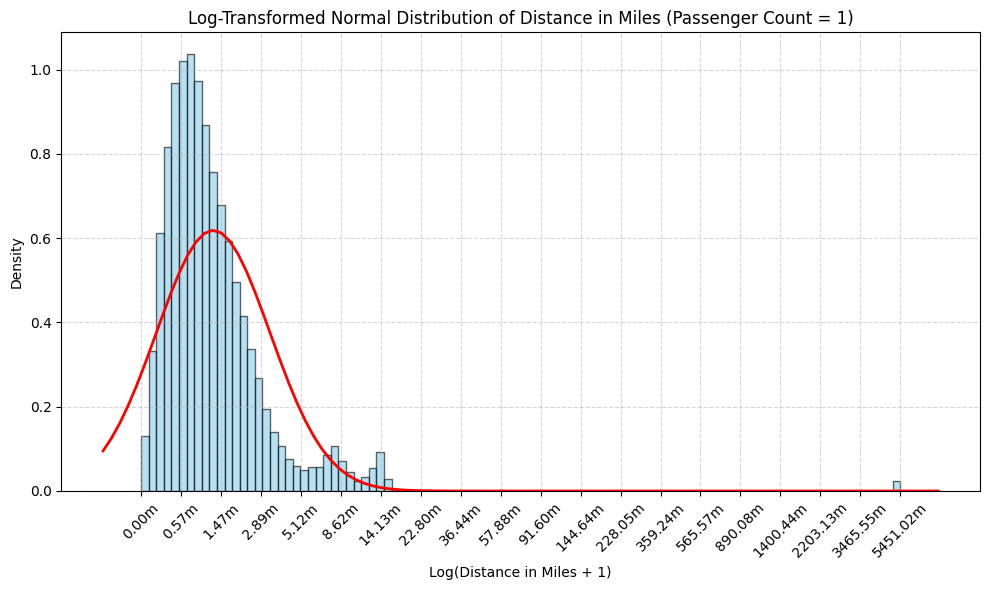

In [67]:
# Assuming 'df' is your original DataFrame
# Filter the DataFrame to only include rows where passenger_count == 1
df_single_passenger = df[df['passenger_count'] == 1].copy()  # Use .copy() to avoid SettingWithCopyWarning

# Apply a log transformation to fare_per_mile to handle the wide range
df_single_passenger['log_distance_miles'] = np.log1p(df_single_passenger['distance_miles'])  # log1p handles log(0) safely as log(1 + x)

# Plotting the histogram of log-transformed fare_per_mile
plt.figure(figsize=(10, 6))
plt.hist(df_single_passenger['log_distance_miles'], bins=100, density=True, edgecolor='black', alpha=0.6, color='skyblue')

# Calculating mean and standard deviation of the log-transformed fare_per_mile column
mean = df_single_passenger['log_distance_miles'].mean()
std_dev = df_single_passenger['log_distance_miles'].std()

# Generating values for the normal distribution curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std_dev)

# Plotting the normal distribution curve
plt.plot(x, p, 'r', linewidth=2)

# Adding plot title and labels
plt.title('Log-Transformed Normal Distribution of Distance in Miles (Passenger Count = 1)')
plt.xlabel('Log(Distance in Miles + 1)')
plt.ylabel('Density')
plt.grid(True, linestyle='--', alpha=0.5)

# Set the x-ticks to cover the range, and show their original fare_per_mile equivalents
ticks = np.linspace(df_single_passenger['log_distance_miles'].min(), df_single_passenger['log_distance_miles'].max(), num=20)
plt.xticks(ticks, labels=[f"{np.exp(tick) - 1:.2f}m" for tick in ticks], rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

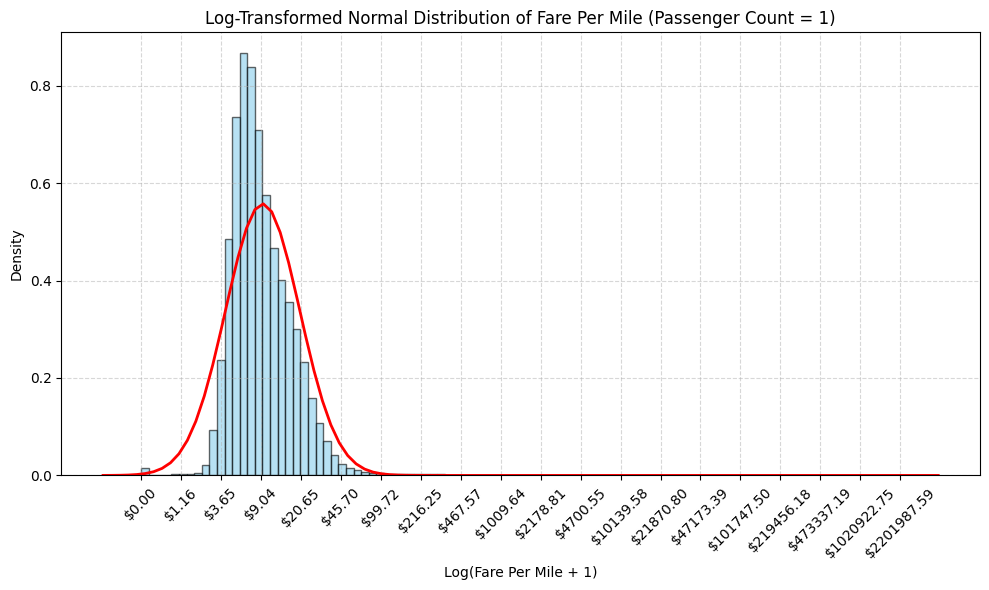

In [58]:
'''
Standard distribution of fare_per_mile. Looks like most people are paying ~$5 per mile.
Note that this is also for 1-x passangers...
'''

# Assuming 'df' is your original DataFrame
# Filter the DataFrame to only include rows where passenger_count == 1
df_single_passenger = df[df['passenger_count'] == 1].copy()  # Use .copy() to avoid SettingWithCopyWarning

# Apply a log transformation to fare_per_mile to handle the wide range
df_single_passenger['log_fare_per_mile'] = np.log1p(df_single_passenger['fare_per_mile'])  # log1p handles log(0) safely as log(1 + x)

# Plotting the histogram of log-transformed fare_per_mile
plt.figure(figsize=(10, 6))
plt.hist(df_single_passenger['log_fare_per_mile'], bins=100, density=True, edgecolor='black', alpha=0.6, color='skyblue')

# Calculating mean and standard deviation of the log-transformed fare_per_mile column
mean = df_single_passenger['log_fare_per_mile'].mean()
std_dev = df_single_passenger['log_fare_per_mile'].std()

# Generating values for the normal distribution curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std_dev)

# Plotting the normal distribution curve
plt.plot(x, p, 'r', linewidth=2)

# Adding plot title and labels
plt.title('Log-Transformed Normal Distribution of Fare Per Mile (Passenger Count = 1)')
plt.xlabel('Log(Fare Per Mile + 1)')
plt.ylabel('Density')
plt.grid(True, linestyle='--', alpha=0.5)

# Set the x-ticks to cover the range, and show their original fare_per_mile equivalents
ticks = np.linspace(df_single_passenger['log_fare_per_mile'].min(), df_single_passenger['log_fare_per_mile'].max(), num=20)
plt.xticks(ticks, labels=[f"${np.exp(tick) - 1:.2f}" for tick in ticks], rotation=45)

# Display the plot
plt.tight_layout()
plt.show()


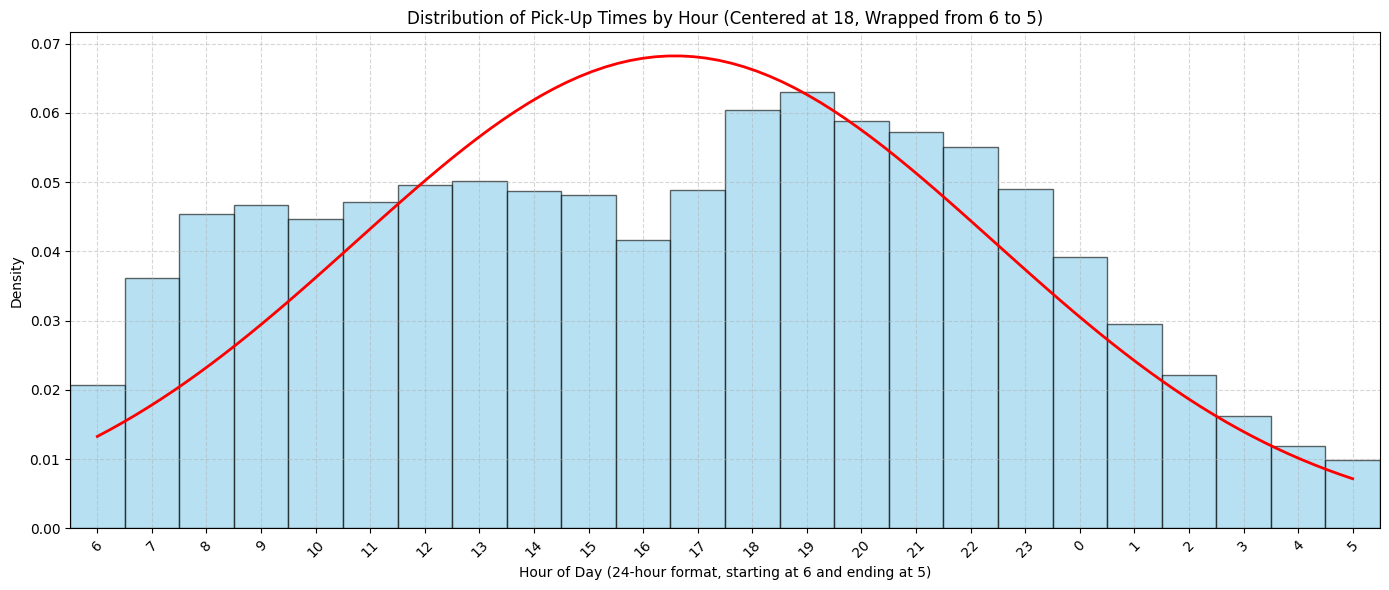

In [59]:
'''
Standard distribution of pickup_datetime
'''

# Assuming 'df' is your original DataFrame containing 'pickup_datetime' column
# Convert 'pickup_datetime' to a datetime object
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

# Extract the hour from 'pickup_datetime'
df['pickup_hour'] = df['pickup_datetime'].dt.hour

# Adjust the pickup_hour column to simulate wrapping for hours beyond 23 (add 24 to hours from 0-5)
df['adjusted_hour'] = df['pickup_hour'].apply(lambda x: x if x >= 6 else x + 24)

# Plotting the histogram of adjusted_hour
plt.figure(figsize=(14, 6))
plt.hist(df['adjusted_hour'], bins=np.arange(5.5, 30.5, 1), density=True, edgecolor='black', alpha=0.6, color='skyblue', align='mid')

# Calculate the mean and standard deviation of the adjusted hour distribution
mean = df['adjusted_hour'].mean()
std_dev = df['adjusted_hour'].std()

# Generate values for the normal distribution curve
x = np.linspace(6, 29, 100)
p = norm.pdf(x, mean, std_dev)

# Plot the normal distribution curve
plt.plot(x, p, 'r', linewidth=2)

# Adjust the x-ticks to include hours from 6 to 23 and then 0 to 5
centered_hours = np.array([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])
centered_labels = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 0, 1, 2, 3, 4, 5]

plt.xticks(centered_hours, labels=centered_labels, rotation=45)

# Extend xlim slightly to ensure no cutting-off at edges
plt.xlim(5.5, 29.5)

# Adding plot title and labels
plt.title('Distribution of Pick-Up Times by Hour (Centered at 18, Wrapped from 6 to 5)')
plt.xlabel('Hour of Day (24-hour format, starting at 6 and ending at 5)')
plt.ylabel('Density')
plt.grid(True, linestyle='--', alpha=0.5)

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

In [60]:

total_distance = df['distance_miles'].sum()
print(f"Total distance traveled: {total_distance:.2f} miles")

Total distance traveled: 2494530.75 miles


In [61]:

avg_fare_by_passenger = df.groupby('passenger_count')['fare_amount'].mean()
print(avg_fare_by_passenger)

passenger_count
0       9.439266
1      11.255358
2      11.786135
3      11.499613
4      11.641991
5      11.214370
6      12.158537
208    11.700000
Name: fare_amount, dtype: float64


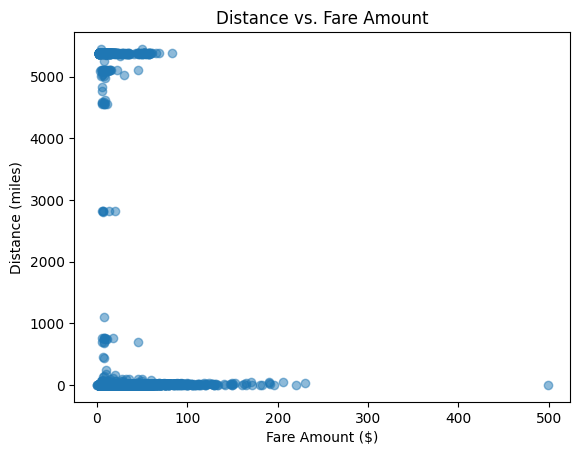

In [62]:
'''
You would expect this to be a linear relationship, as distance increases the price increases, but this isn't the case.
'''
plt.scatter(df['fare_amount'], df['distance_miles'], alpha=0.5)
plt.title('Distance vs. Fare Amount')
plt.ylabel('Distance (miles)')
plt.xlabel('Fare Amount ($)')
plt.show()


In [63]:
# Select key numerical columns for correlation analysis
numerical_columns = ['fare_amount', 'distance_miles', 'passenger_count']

# Extract the relevant numerical data
df_numerical = df[numerical_columns]

# Drop rows with NaN values to avoid issues in correlation calculation
df_numerical = df_numerical.dropna()

# Calculate the correlation matrix
correlation_matrix = df_numerical.corr()
correlation_matrix

,fare_amount,distance_miles,passenger_count
fare_amount,1.000000,0.026011,0.011824
distance_miles,0.026011,1.000000,-0.002111
passenger_count,0.011824,-0.002111,1.000000


In [64]:
'''
1. Correlation Between fare_amount and distance_miles (0.026011)
Interpretation: The correlation coefficient is approximately 0.026, indicating a very weak positive relationship between fare_amount and distance_miles.

Implications:
This result suggests that fare_amount is not strongly dependent on distance_miles alone. 
While longer trips are generally expected to have higher fares, other factors (e.g., traffic, time of day, surge pricing, and fixed base fares) 
likely play significant roles in determining the total fare.

For Uber's business model, this means that charging customers is not solely based on distance traveled; 
pricing strategies such as surge pricing, base fares, and dynamic pricing likely have a substantial impact.



2. Correlation Between fare_amount and passenger_count (0.011824)
Interpretation: The correlation coefficient is approximately 0.012, indicating a very weak positive relationship between fare_amount and passenger_count.

Implications:
This suggests that the number of passengers has little to no impact on the fare amount. 
In most cases, Uber charges the same fare regardless of whether there is one passenger or multiple passengers in the ride.

This aligns with Uber's standard fare structure, where fares are based on distance, time, and demand rather than the number of passengers, 
making Uber rides attractive for groups since the cost doesn't increase per additional passenger.



3. Correlation Between distance_miles and passenger_count (-0.002111)
Interpretation: The correlation coefficient is approximately -0.002, indicating virtually no relationship between distance_miles and passenger_count.

Implications:
This result suggests that trip distances are independent of the number of passengers. Whether there’s one passenger or more does not affect the length of the trips being taken.

This indicates that Uber services cater equally to individual riders and groups for various distances, supporting Uber's ability to serve both short and long-distance trips effectively.

'''

"\n1. Correlation Between fare_amount and distance_miles (0.026011)\nInterpretation: The correlation coefficient is approximately 0.026, indicating a very weak positive relationship between fare_amount and distance_miles.\n\nImplications:\nThis result suggests that fare_amount is not strongly dependent on distance_miles alone. \nWhile longer trips are generally expected to have higher fares, other factors (e.g., traffic, time of day, surge pricing, and fixed base fares) \nlikely play significant roles in determining the total fare.\n\nFor Uber's business model, this means that charging customers is not solely based on distance traveled; \npricing strategies such as surge pricing, base fares, and dynamic pricing likely have a substantial impact.\n\n\n\n2. Correlation Between fare_amount and passenger_count (0.011824)\nInterpretation: The correlation coefficient is approximately 0.012, indicating a very weak positive relationship between fare_amount and passenger_count.\n\nImplications:\